# 9.1 序列建模

序列建模是一种用于处理序列数据的机器学习技术。序列建模的目标通常是将序列数据转换为固定的表示方法，然后使用这种表示方法进行分类、聚类、回归或者其他任务。序列建模的常用方法包括序列分类、序列标注、序列生成和序列预测等。

## 9.1.1 序列数据

既然说要解决序列数据问题，那么首先应该明确它的范围，什么样的数据可以称为序列数据。

序列数据是指具有序列特征的数据。在序列数据中，每一项数据都有一个与之相对应的位置，且后一项数据可能会受到前一项数据的影响。

序列数据的种类很多，主要包括以下三种类型：时间序列、文本序列、图像序列。

### 9.1.1.1 时间序列

时间序列数据很好理解，就是指按照时间顺序排列的数据。常见的时间序列数据包括：

环境数据：比如每小时的气温、每天的降雨量、每月的二氧化碳浓度等。

经济数据：比如每天的股票价格、每月的通货膨胀率、每年的 GDP 等。

社会数据：比如交通流量、每月的就业率、每年的人口数量等。

健康数据：比如心率、血压、体重等。

行为数据：比如电话通话次数、每周的社交活动次数、每月的出行次数等。

### 9.1.1.2 文本序列

文本序列是指由一串有序的文本组成的序列。文本序列可以是一句话、一篇文章、一组评论等。在文本序列中，每一个文本部分都有一个与之相对应的位置，且后一部分文本可能会受到前一部分文本的影响。

大家现在看到的这篇文章，其实也是文本序列数据。

### 9.1.1.3 图像序列

图像序列是指由一组有序的图像组成的序列。图像序列可以是动画、视频等。在图像序列中，每一帧图像都有一个与之相对应的位置，且后一帧图像可能会受到前一帧图像的影响。

我们说手写数字识别不是序列数据，是应为它的上一张和下一张图像并没有联系。

### 9.1.1.4 时间序列数据可视化

说了这么多，不如动手实际导入一个时间序列数据。我们以金融数据为例，看看什么是时间序列数据。这里我们使用一个新的代码包，pandas_datareader,它里面有许多国外金融数据集，非常方便。
GS10数据是最近五年月度的美国10年期国债固定收益，我们把它导入进来看看。

In [2]:
import pandas_datareader as pdr
gs10 = pdr.get_data_fred('GS10')
gs10.head()

,GS10
DATE,
2018-02-01,2.86
2018-03-01,2.84
2018-04-01,2.87
2018-05-01,2.98
2018-06-01,2.91


用matplotbib绘制一下图形看看。

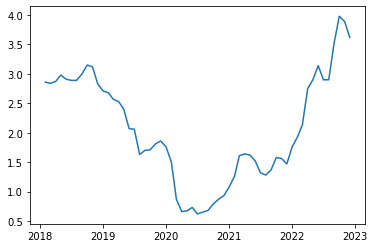

In [3]:
import matplotlib.pyplot as plt
plt.plot(gs10)
plt.show()

我们绘制出了从2018年到今年，每个月的美国10年期国债收益率，从图中大家可以看出一些规律吗？

## 9.1.2 序列模型

对这种序列数据进行预测的模型，就被称为序列模型。 比如在上面美国国债的数据集中，我们用$t$表示时间,$x_t$表示价格，我们想要通过之前所有的数据，预测t时间的数据，可以通过下面这个公式：

$$x_t \sim P(x_t|x_{t-1},\dots,x_1)$$

为了实现这个预测，我们可以建立一个回归预测模型。

## 9.1.3 序列建模

下面我们用pytorch建立一个模型来实现序列数据的回归预测。

首先是数据集，我们想要构建一个序列模型，也就是用$x_{t-1},\dots,x_{t-n}$去预测$x_t$，这里的n是一个超参数，表示我们要用多少个数据去预测下一个数据。这里需要我们对数据集进行一下处理，生成$X_t={x_{t-1},\dots,x_{t-n}}，y_t = x_t$这样形式的一组数据。然后再用DataLoader来读入数据集。具体代码如下：

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#构造数据集
num = len(gs10)
time = torch.arange(1, num+1, dtype= torch.float32)
x = torch.tensor(gs10['GS10'].to_list())
n = 6
features = torch.zeros((num - n, n))
for i in range(n):
    features[:, i] = x[i: num - n + i]
    
labels = x[n:].reshape((-1, 1))
train_loader = DataLoader(TensorDataset(features[:num-n], labels[:num-n]), 4, shuffle=True)

接下来我们构建一个简单的神经网络模型来进行模型。

100%|██████████| 10/10 [00:00<00:00, 129.34it/s]

Epoch 1: Validation loss = 3.6255
Epoch 2: Validation loss = 0.4247
Epoch 3: Validation loss = 0.3386
Epoch 4: Validation loss = 0.2181
Epoch 5: Validation loss = 0.1744
Epoch 6: Validation loss = 0.1521
Epoch 7: Validation loss = 0.1500
Epoch 8: Validation loss = 0.1383
Epoch 9: Validation loss = 0.1359
Epoch 10: Validation loss = 0.1312


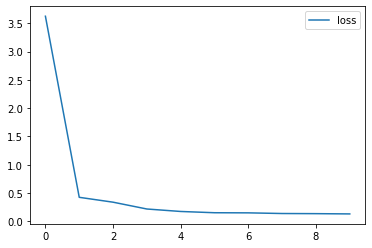

In [7]:
from torch import nn
from tqdm import *

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(6, 10)
        self.linear2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# 建立模型
lr = 0.01
model = Model()
criterion = nn.MSELoss(reduction='none')
trainer = torch.optim.Adam(model.parameters(), lr)

num_epochs = 10
loss_history = []


for epoch in tqdm(range(num_epochs)):
    # 批量训练
    for X, y in train_loader:
        trainer.zero_grad()
        l = criterion(model(X), y)
        l.sum().backward()
        trainer.step()
     # 输出损失
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X, y in train_loader:
            outputs = model(X)
            l = criterion(outputs, y)
            total_loss += l.sum()/l.numel()
        avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}: Validation loss = {avg_loss:.4f}')
    loss_history.append(avg_loss)
    
# 使用图表库（例如Matplotlib）绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.legend()
plt.show()


可以看到模型经过10轮的训练，模型收敛的比较好。

## 9.1.4 模型预测

接下来我们用它来进行预测，看一下序列模型的效果。我们使用的方法是单步预测，单步预测是指，使用序列模型对序列数据进行预测，只预测序列的下一个元素，一起来看一下。

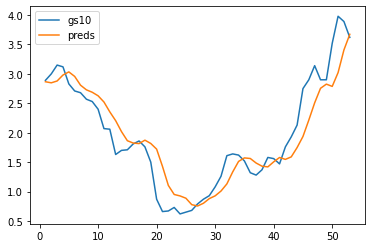

In [12]:
preds = model(features)

plt.plot(time[:num-6], gs10['GS10'].to_list()[6:num], label='gs10')
plt.plot(time[:num-6], preds.detach().numpy(), label='preds')
plt.legend()
plt.show()

单步预测的目标是提前预测出序列的下一个元素，以便在实时场景下处理序列数据。

可以看到，虽然预测结果和真实值仍有差异，但大的趋势基本一致。

**梗直哥提示：本节我们学习了什么是序列数据，并用时间序列数据进行建模，并看到了单步预测的结果。实际上除了单步预测，还存在多步预测，比如我们想要在$x_t$时间步预测$x_{t+k}$的输出，就是k步预测。只不过随着k值的增加，预测质量会直线下降。更加详细的知识点的掌握，有赖于你在实战中总结经验，慢慢就熟悉了。当然，如果你想大幅节省时间，解答自己在学习中的各种困惑，欢迎选修《梗直哥深度学习：python实战》。**